# Comparison of Adjacent TMA sections and Single versus Standard IF

**Visualization:** Multi-color overlays automatically generated.

**Samples:** 
- Cyclic and standard IF adjacent sections
- Adjacent sections of HER2 + TMA

**Method**: Often images in publications are not reproducible: the ROI selected and the display range are not documented. This code allows for fully reproducible visualizations of image data.

In [1]:
#libraries
import os
import pandas as pd
import numpy as np
import subprocess
from itertools import compress
import shutil
import importlib
import skimage
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
pwd

'/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation'

In [3]:
#important paths
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir = os.getcwd()
figdir = f'{codedir}/Figures'
if not os.path.exists(figdir):
    print('making directory')
    os.mkdir(figdir)

In [4]:
os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cmIF')
from mplex_image import preprocess, process, analyze, mpimage, cmif

In [5]:
%matplotlib inline

# Figure 1: Visualization of standard vs cycIF

Download necessary images from synapse.org, ID =  'syn23644791'

https://www.synapse.org/#!Synapse:syn23644791

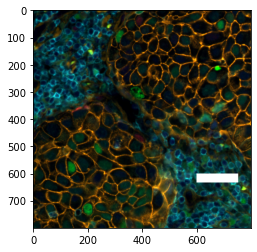

In [19]:
#single vs cyclic

#cropping coordinates
d_crop = {'44290-112':(5100,8900),
 '44290-113':(6030,8211),
 '44290-114':(5210,9242),
 '44290-115':(6250,10590),
 '44290-116':(6636,9274),
 '44294-116':(9947,5959),
 '44294-117':(12480,6592),
 '44294-118':(11301, 6882),
 '44294-119':(10253,5857),
 '44294-120':(10450,5810),
 }

d_process = {
    '44290':f'{codedir}/Images/tiff/44290',
 }
#load image and exposure time dataframe
df_img = pd.read_csv(f'{codedir}/Metadata/44290/SNR_single_vs_cyclic.csv',index_col=0)
df_img.index = [item.replace('20191104_ValidationStudies','cycIF_ValidationStudies') for item in df_img.index]
df_img['experimenttype'] = [item.split('_')[2] for item in df_img.condition] 
df_img['experiment'] = [item.split('_')[0] for item in df_img.condition] 
df_img['singlerounds'] = [item.split('_')[1] for item in df_img.condition] 
df_img['scene'] = df_img.slide

for idx,(s_sample, s_path) in enumerate(d_process.items()):
    if not os.path.exists(f'{figdir}/{s_sample}'):
        os.mkdir(f'{figdir}/{s_sample}')
    os.chdir(s_path)
    df_dapi = mpimage.parse_org()
    df_dapi = df_dapi[df_dapi.color=='c1']
    df_img['path'] = [f'{s_path}/{item}' for item in df_img.index]
    df_dapi['path'] = [f'{s_path}/{item}' for item in df_dapi.index]
    #make multicolor png for figure 1 (800x800 pixel)
    d_overlay = {'R2':[ 'PCNA','Her2','ER','CD45'],
     'R3':['pH3', 'CK14', 'CD44', 'CK5'],
     'R4':[ 'Vim', 'CK7', 'PD1', 'LaminAC',],
     'R5':['aSMA', 'CD68', 'Ki67', 'Ecad'],
     }
    
    for s_tissue in ['tumor','normal']:
        if s_tissue == 'tumor':
            es_dim = {'nada'}
            es_bright={'pH3','CK14','CK5'}
        else:
            es_dim = {'nada'}
            es_bright={'Ki67','pH3'}
        df_tissue = df_img[(df_img.experimenttype==s_tissue) & (df_img.rounds!='R6')]
        for s_type in ['single','cyclic']: 
            df_type = df_tissue[df_tissue.experiment==s_type]
            for s_round in ['R2','R3','R4','R5']:
                if s_type == 'single':
                    df_round = df_type[df_type.singlerounds==s_round]
                else:
                    df_round = df_type[df_type.rounds==s_round]
                s_slide = df_round.slide[0]
                df_dapi_round = df_dapi[(df_dapi.scene==s_slide) & (df_dapi.rounds=='R5') & (df_dapi.color=='c1')]
                if df_type.scene[0] == '44294-116':
                        df_dapi_round = df_dapi[(df_dapi.scene==s_slide) & (df_dapi.rounds=='R4') & (df_dapi.color=='c1')]
                else:
                        df_dapi_round = df_dapi[(df_dapi.scene==s_slide) & (df_dapi.rounds==s_round) & (df_dapi.color=='c1')]

                high_thresh=0.999
                d_overlay_round = {s_round:d_overlay[s_round]}
                d_result = mpimage.multicolor_png(df_round,df_dapi,s_scene=df_round.scene[0],d_overlay=d_overlay_round,d_crop=d_crop,es_dim=es_dim,es_bright=es_bright,low_thresh=1000,high_thresh=high_thresh)
                for key, tu_result in d_result.items():
                    skimage.io.imsave(f'{figdir}/{s_sample}/ColorArray_{df_round.scene[0]}_{key}_{".".join(tu_result[0])}.png',tu_result[1])
                    tu_result[1][600:633,600:753] = [255,255,255]
                    im_scale = tu_result[1]
                    skimage.io.imsave(f'{figdir}/{s_sample}/ColorArray_{df_round.scene[0]}_{key}_{".".join(tu_result[0])}_scalebar.png',im_scale)
                    if key == 'R2':
                        if s_tissue == 'tumor':
                            plt.imshow(tu_result[1])
                break
            break


In [7]:
#segment with cellpose for tissue loss calculation
#### 7 Spawn Cellpose Segmentation Jobs ####
# source activate cellpose or cellpose_gpu

ls_sample = ['44290-112',# '44290-113', '44290-114', '44290-115', '44290-116',
             '44294-116',# '44294-117', '44294-118', '44294-119', '44294-120'
            ]
'''
import os
codedir = os.getcwd()
codedir='/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation'
os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cmIF')
from mplex_image import segment
regdir = f'{codedir}/Images/tiff/44290'
segdir = f'{codedir}/Images/tiff/44290/seg'
nuc_diam = 30
cell_diam = 30 

s_seg_markers = "['Ecad']"
s_type = 'cell' #'nuclei'# 

print(f'Predicting {s_type}')
for s_sample in ls_sample:
    segment.segment_spawner(s_sample,segdir,regdir,nuc_diam,cell_diam,s_type,s_seg_markers,s_job='cpu',s_match='both') #both/seg/match
    #break

'''
#### 8a Extract Cellpose Features ####
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cmIF')
from mplex_image import features
regdir = f'{codedir}/Images/tiff/44290'
segdir = f'{codedir}/Images/tiff/44290/seg'
nuc_diam = 30
cell_diam = 30 
ls_seg_markers = ['Ecad']

for s_sample in ls_sample: 
    df_sample, df_thresh = features.extract_cellpose_features(s_sample, segdir, regdir, ls_seg_markers, nuc_diam, cell_diam)
    df_sample.to_csv(f'{segdir}/features_{s_sample}_MeanIntensity_Centroid_Shape.csv')
    df_thresh.to_csv(f'{segdir}/thresh_{s_sample}_ThresholdLi.csv')

#### 9 Filter cellpose features #### 
'''
from mplex_image import process, features

#parameters
nuc_diam = 30  # ok (microscope dependent)
cell_diam = 30  # ok (microscope dependent)
ls_seg_markers = ['Ecad'] # ok 
s_thresh='Ecad' #  defind cell segementation marker
ls_membrane = ['HER2','EGFR'] # pannel dependent
ls_marker_cyto = ['CK14','CK5','CK17','CK19','CK7','CK8','Ecad','EGFR','HER2'] # pannel dependent use df_img_all.marker.unique() all cancer cell marker (cytoplasm)
ls_custom = ['HER2_cellmem25','EGFR_cellmem25','CCND1_nuclei', 'MUC1_perinuc5', 'CAV1_perinuc5', 'CSF1R_perinuc5']  # pandel dependent from process.filter_loc_cellpose output below. specify _nuclei and _perinuc5  (figure out wich by human protein atlas or Koei).
ls_filter = ['DAPI11_nuclei','DAPI2_nuclei']  # user qc images to defined this! (usually dapi2 because dapi1 might be hazzy and last good dapi) and additional bad rounds inbetween.
ls_shrunk = [] #'Vim_perinuc3','CD44_perinuc3'
man_thresh = 1200 # manual treshold Ecad by Zen look at pixel value

for s_sample in ls_sample: 
    os.chdir(segdir)
    break
    df_img_all = process.load_li([s_sample], s_thresh, man_thresh)
    process.marker_table(df_img_all,qcdir) # for presentation
    df_mi_full = process.load_cellpose_df([s_sample], segdir) # all standard segements
    df_xy = process.filter_cellpose_xy(df_mi_full) # get cell coordinate and calculates nucles area and nucleus eccentry
    df_mi_full, i_max = process.drop_last_rounds(df_img_all, ls_filter, df_mi_full)
    df_mi_filled = process.fill_cellposresult_HTA9-1-33_cellsatop_dictionary.jsone_nas(df_mi_full, ls_marker_cyto, s_thresh=s_thresh, man_thresh=man_thresh)  # in other words use perinuc5 for Ecad negative cells (cancer, immune, fibroblasts, ...).
    #skip df_mi_filled = process.shrink_seg_regions(df_mi_filled,s_thresh,ls_celline=[],ls_shrunk=ls_shrunk)
    df_mi_mem_fill = process.fill_bright_nas(ls_membrane, s_sample, s_thresh, df_mi_filled, segdir) # same for cell membranemarkers with perinuc5 membrane (4 xp, 75 percentile)
    df_mi,es_standard = process.filter_loc_cellpose(df_mi_mem_fill, ls_marker_cyto, ls_custom) # the df_mi is the filtered columns (final) output.
    df_pos_auto, d_thresh_record = process.auto_threshold(df_mi, df_img_all)  # df_img_all.threshold_li is integratd in process.auto_threshold function (ok for DAPI, there better then ozzu).
    #skip ls_color = process.plot_thresh_results(df_img_all,df_pos_auto,d_thresh_record,df_xy,i_max,s_thresh,qcdir)
    ls_color = [item + '_nuclei' for item in df_img_all[(df_img_all.round_ord<=i_max) & (df_img_all.slide_scene==df_img_all.slide_scene.unique()[0]) & (df_img_all.marker.str.contains('DAPI'))].marker.tolist()]  # we tresholded everithing but actually only have to focus on DAPI
    df_mi_filter = process.filter_dapi_cellpose(df_pos_auto, ls_color, df_mi, ls_filter, qcdir)  # filter by (final) row output
    # df_mi_filter.shape is how many cell we had after round 11 (ls_filter).
    # this is how many cell we had in round 1 or 2 (ls_filter): df_pos_auto.loc[:,'DAPI1_nuclei'].sum()
    
    # save to file
    df_mi_filter.to_csv(f'{segdir}/features_{s_sample}_FilteredMeanIntensity_{"_".join([item.split("_")[0] for item in ls_filter])}.csv')
    df_xy.to_csv(f'{segdir}/features_{s_sample}_CentroidXY.csv')

    # get new segmentation labels for 
    labels, combine, dd_result = features.combine_labels(s_sample, segdir, subdir, ls_seg_markers, nuc_diam, cell_diam, df_mi_filled, s_thresh)
    # writes a new tiff file ..._cell30_exp5_... the final cell segemention basinfile.
    # write result_HTA9-1-33_cellsatop_dictionary.json for cells with more then one nucei or so.
'''

Predicting cell
Processing 44290-112
Next
Processing 44294-116
Next


# Figure 3 a-b: TMA replicates

Download images from:

syn23644810  https://www.synapse.org/#!Synapse:syn23644810

syn23644811  https://www.synapse.org/#!Synapse:syn23644811

syn23644812  https://www.synapse.org/#!Synapse:syn23644812

In [16]:
#replicate

df_img_all = pd.read_csv(f'{codedir}/Metadata/BM-Her2N75/SNR_jenny_replicates.csv',index_col=0)
df_img_all.index = [item.replace('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20191104_ValidationStudies',f'{codedir}') for item in df_img_all.index]
df_img_all['slide'] = [item.split('-Scene-')[0] for item in df_img_all.tissue]
df_img_all['scene'] = [item.split('-Scene-0')[1] for item in df_img_all.tissue]

#20200423 make multicolor png for figure 3 (800x800 pixel)
d_overlay = {'R1':['CD20','CD8','CD4','CK19'],
    'R2':[ 'PCNA','Her2','ER','CD45'],
     'R3':['pH3', 'CK14', 'CD44', 'CK5'],
     'R4':[ 'Vim', 'CK7', 'PD1', 'LaminAC',],
     'R5':['aSMA', 'CD68', 'Ki67', 'Ecad'],
     }

d_crop ={
    'BM-Her2N75-15-Scene-059':(2060,4000),
    'BM-Her2N75-17-Scene-059':(2049,4530),
    'BM-Her2N75-18-Scene-059':(3100,3760),
    'BM-Her2N75-15-Scene-017':(2260,2500),
    'BM-Her2N75-17-Scene-017':(2107,2795),
    'BM-Her2N75-18-Scene-017':(3189,3982),
    'BM-Her2N75-15-Scene-049':(3866,3379),
    'BM-Her2N75-17-Scene-049':(3809,3797),
    'BM-Her2N75-18-Scene-049':(2948,3099),
  }

for s_scene in ['17','49','59']: 
    if s_scene == '59':
        es_bright = {'CK14','CK5','pH3','CD68','ER'}
    else:
        es_bright = {'pH3','CD68','CK14','CK5'}
    df_scene = df_img_all[(df_img_all.scene==s_scene)]
    for s_sample in ['BM-Her2N75-18','BM-Her2N75-17','BM-Her2N75-15']:
        s_path = f'{codedir}/Images/tiff/{s_sample}'
        os.chdir(s_path)
        df_dapi = mpimage.parse_org()
        df_dapi = df_dapi[df_dapi.color=='c1']
        df_dapi['path'] = [f'{s_path}/{item}' for item in df_dapi.index]
        if not os.path.exists(f'{figdir}/{s_sample}'):
            os.mkdir(f'{figdir}/{s_sample}')
        df_slide = df_scene[df_scene.slide==s_sample]
        df_slide.loc[:,'path'] = df_slide.index
        for s_round in ['R1','R5','R2','R3','R4']:
            df_round = df_slide[df_slide.rounds==s_round]
            s_slide_scene = f'{s_sample}-Scene-0{s_scene}'
            df_round.loc[:,'scene'] = s_slide_scene
            df_dapi_round = df_dapi[(df_dapi.rounds==s_round) & (df_dapi.scene == s_slide_scene)]
            high_thresh=0.999
            d_overlay_round = {s_round:d_overlay[s_round]}
            d_result = mpimage.multicolor_png(df_round,df_dapi_round,s_scene=s_slide_scene,d_overlay=d_overlay_round,d_crop=d_crop,es_dim={'nada'},es_bright=es_bright,low_thresh=2000,high_thresh=high_thresh)
            for key, tu_result in d_result.items():
                skimage.io.imsave(f'{figdir}/{s_sample}/ColorArray_{s_slide_scene}_{key}_{".".join(tu_result[0])}.png',tu_result[1])
                tu_result[1][600:633,600:753] = [255,255,255]
                im_scale = tu_result[1]
                skimage.io.imsave(f'{figdir}/{s_sample}/ColorArray_{s_slide_scene}_{key}_{".".join(tu_result[0])}_scalebar.png',im_scale)
         
                if key == 'R2':
                    if s_scene == '49':
                        plt.imshow(tu_result[1])
            break
        break



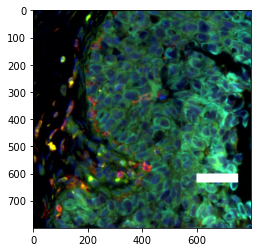

In [17]:
plt.imshow(tu_result[1])